<a href="https://colab.research.google.com/github/Ejedavy/Machine-Learning-projects/blob/main/MNISTAnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [143]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets
from torch.utils.data import dataloader
from torchvision import transforms
import matplotlib.pyplot as plt

In [144]:
class MNISTNN(nn.Module):
  def __init__(self, input_size, output_size):
    super(MNISTNN, self).__init__()
    self.fc1 = nn.Linear(input_size, 50)
    self.fc2 = nn.Linear(50, output_size)

  def forward(self, x):
    x = self.fc1(x)
    x = F.relu(x)
    return self.fc2(x)

In [145]:
class CNNMNIST(nn.Module):
  def __init__(self, in_channels = 1, num_classes = 10):
    super(CNNMNIST, self).__init__()
    self.conv1 = nn.Conv2d(in_channels = in_channels, out_channels = 8, kernel_size = (3, 3,), stride = (1, 1), padding =(1, 1))
    self.conv2 = nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = (3, 3,), stride = (1, 1), padding =(1, 1))
    self.pool = nn.MaxPool2d(stride=(2, 2), kernel_size = (2, 2))
    self.fc1 = nn.Linear(16 * 7 * 7, 90)
    self.fc2 = nn.Linear(90, 10)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.pool(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = self.pool(x)
    x = x.reshape(x.shape[0], -1)
    x = F.relu(self.fc1(x))
    return self.fc2(x)

In [146]:
class OptimizedMNIST(nn.Module):
  def __init__(self, in_channels = 1, num_classes = 10):
    super(OptimizedMNIST, self).__init__()
    self.conv1 = nn.Conv2d(in_channels = in_channels, out_channels = 8, kernel_size = (3, 3), stride = (1, 1), padding = (1, 1))
    self.normalization1 = nn.BatchNorm2d(num_features = 8)
    self.conv2 = nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = (3, 3,), stride = (1, 1), padding =(1, 1))
    self.normalization2 = nn.BatchNorm2d(num_features = 16)
    self.conv3 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = (3, 3,), stride = (1, 1), padding =(1, 1))
    self.normalization3 = nn.BatchNorm2d(num_features = 32)
    self.pool = nn.MaxPool2d(stride=(2, 2), kernel_size = (2, 2))
    self.fc1 = nn.Linear(32 * 3 * 3, 100)
    self.fc2 = nn.Linear(100, 100)
    self.fc3 = nn.Linear(100, 100)
    self.fc4 = nn.Linear(100, 100)
    self.fc5 = nn.Linear(100, 90)
    self.fc6 = nn.Linear(90, num_classes)
    self.dropout= nn.Dropout(p = 0.35)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(self.normalization1(x))
    x = self.pool(x)
    x = self.conv2(x)
    x = F.relu(self.normalization2(x))
    x = self.pool(x)
    x = self.conv3(x)
    x = F.relu(self.normalization3(x))
    x = self.pool(x)
    x = x.reshape(x.shape[0], -1)
    x = self.dropout(F.relu(self.fc1(x)))
    x = self.dropout(F.relu(self.fc2(x)))
    x = self.dropout(F.relu(self.fc3(x)))
    x = self.dropout(F.relu(self.fc4(x)))
    x = self.dropout(F.relu(self.fc5(x)))
    x = self.fc6(x)

    return x

In [147]:
transformation =   transforms.Compose([transforms.ToTensor(),  transforms.Normalize((0.1307,), (0.3081,))])

In [148]:
train_data = datasets.MNIST(root = "/datasets", train = True, transform = transformation, download = True)

In [149]:
test_data = datasets.MNIST(root = "/datasets", train = False, transform = transformation, download = True)

In [150]:
# Create the data loader

In [151]:
print(train_data[0][0].shape)

torch.Size([1, 28, 28])


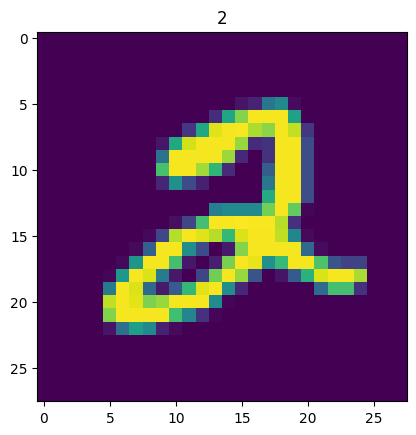

In [152]:
plt.title(train_data[5][1])
plt.imshow(train_data[5][0].squeeze(0))

In [153]:
BATCH_SIZE = 64
LEARNING_RATE = 0.005
EPOCH = 100

In [154]:
model = MNISTNN(28 * 28, 10)

In [155]:
model = CNNMNIST(in_channels = 1, num_classes = 10)

In [156]:
model = OptimizedMNIST()

In [157]:
train_loader = dataloader.DataLoader(dataset = train_data, batch_size= BATCH_SIZE, shuffle = True)
test_loader = dataloader.DataLoader(dataset = test_data, batch_size= BATCH_SIZE, shuffle= True)

In [158]:
optmizer = optim.Adam(lr = LEARNING_RATE, params = model.parameters(), weight_decay = 0.001)
loss = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optmizer, step_size=10, gamma=0.1)

In [159]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [160]:
def check_accuracy(model, loader):
  model.eval()
  total_samples = 0
  correct_predictions =  0
  model.to(device)
  with torch.no_grad():
    for x, y in loader:
      x = x.to(device)
      y = y.to(device)
      #x = x.reshape(x.shape[0], - 1)
      pred = model(x)
      _, pred = pred.max(1)
      correct_predictions += sum(pred == y)
      total_samples += len(y)
  return correct_predictions / total_samples 

In [161]:
def check_losses(model, loader):
  model.eval()
  running_loss = 0
  total_sample = 0
  with torch.no_grad():
    for x, y in loader:
      x = x.to(device)
      y = y.to(device)

      pred = model(x)
      c_loss = loss(pred, y)
      running_loss += c_loss.item()
      total_sample += len(loader)
  return running_loss / total_sample

In [162]:
model = model.to(device)
history ={"training_accuracy":[], "val_accuracy": [], "training_loss": [], "val_loss": []}
for epoch in range(EPOCH):
  model.train()
  scheduler.step()
  for batch_idx, (data, target) in enumerate(train_loader):
    data = data.to(device)
    target = target.to(device)
    #data = data.reshape(data.shape[0], - 1)

    output = model(data)
    l2_lambda = 0.001  # Adjust the regularization strength as desired
    l2_reg = torch.tensor(0., requires_grad=True)
    for param in model.parameters():
        l2_reg = l2_reg + torch.norm(param)

    current_loss = loss(output, target) + (l2_lambda * l2_reg)
  
    optmizer.zero_grad()

    current_loss.backward()

    optmizer.step()

  training_accuracy = check_accuracy(model, train_loader)
  val_accuracy = check_accuracy(model, test_loader)
  training_loss = check_losses(model, train_loader)
  val_loss = check_losses(model, test_loader)

  history["training_accuracy"].append(training_accuracy)
  history["val_accuracy"].append(val_accuracy)
  history["training_loss"].append(training_loss)
  history["val_loss"].append(val_loss)


  print(f"Epoch {epoch+ 1} / {EPOCH}, Training accuracy: {training_accuracy:.4f}, Validation Accuracy : {val_accuracy:.4f}, Training Loss: {training_loss:.6f}, Validation Loss: {val_loss:.6f}")

Epoch 1 / 100, Training accuracy: 0.9305, Validation Accuracy : 0.9298, Training Loss: 0.000291, Validation Loss: 0.001724
Epoch 2 / 100, Training accuracy: 0.9652, Validation Accuracy : 0.9664, Training Loss: 0.000172, Validation Loss: 0.000985
Epoch 3 / 100, Training accuracy: 0.9740, Validation Accuracy : 0.9772, Training Loss: 0.000117, Validation Loss: 0.000633
Epoch 4 / 100, Training accuracy: 0.9791, Validation Accuracy : 0.9804, Training Loss: 0.000107, Validation Loss: 0.000568
Epoch 5 / 100, Training accuracy: 0.9824, Validation Accuracy : 0.9828, Training Loss: 0.000088, Validation Loss: 0.000488
Epoch 6 / 100, Training accuracy: 0.9778, Validation Accuracy : 0.9770, Training Loss: 0.000111, Validation Loss: 0.000699
Epoch 7 / 100, Training accuracy: 0.9824, Validation Accuracy : 0.9837, Training Loss: 0.000097, Validation Loss: 0.000548
Epoch 8 / 100, Training accuracy: 0.9805, Validation Accuracy : 0.9814, Training Loss: 0.000092, Validation Loss: 0.000522
Epoch 9 / 100, T

KeyboardInterrupt: ignored

In [ ]:
history = [x.data for x in history]